In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
%matplotlib inline

In [15]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [16]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
dataset_fname = 'bursi.pos.gspan'
def get_graphs(size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [17]:
%%time
'''
induce a grammar and train an estimator
'''
from graphlearn.graphlearn import GraphLearnSampler
training_graphs = get_graphs(size=500)
sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],min_cip_count=2, min_interface_count=2)
sampler.fit(training_graphs,n_jobs=-1,batch_size=10)


Classifier:
SGDClassifier(alpha=0.000658833496989, average=False, class_weight=None,
       epsilon=0.1, eta0=0.738789319334, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=93, n_jobs=1,
       penalty='l1', power_t=0.571719117167, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
CPU times: user 22.9 s, sys: 2.19 s, total: 25.1 s
Wall time: 30.8 s


preprocessing grammar
_sample_notes: None
accept_annealing_factor: 0.9
accept_static_penalty: 0.0
batch_size: 1
   burnout: 0
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000658833496989, average=False, class_weight=None,
       epsilon=0.1, eta0=0.738789319334, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=93, n_jobs=1,
       penalty='l1', power_t=0.571719117167, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x10a5dcef0>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x111805368>
generator_mode: False
hash_bitmask: 1048575
keep_duplicates: False
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x112e88dd0>
    n_jobs: -1
   n_steps: 60
      nbit: 20
node_entity_check: <function <lambda> at 0x10a5e97d0>
postpr

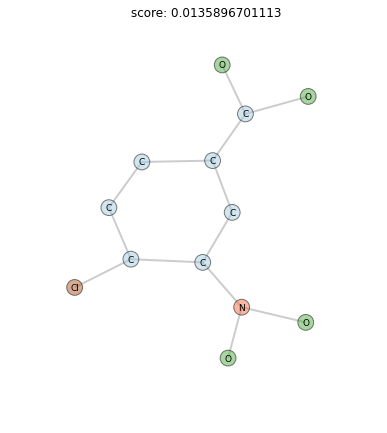

Graph id: 51
iteration:0
iteration:14
iteration:14
Working with 1 cores
Working with 2 cores
Working with 7 cores
iteration:1
iteration:15
iteration:15
Working with 12 cores
Working with 2 cores
Working with 13 cores
iteration:2
iteration:16
iteration:16
Working with 0 cores
Working with 2 cores
Working with 11 cores
printing le errer
iteration:17
iteration:17
Working with 0 cores
Working with 1 cores
printing le errer
iteration:18
grammar
Working with 6 cores
iteration:19
Working with 0 cores
printing le errer
grammar


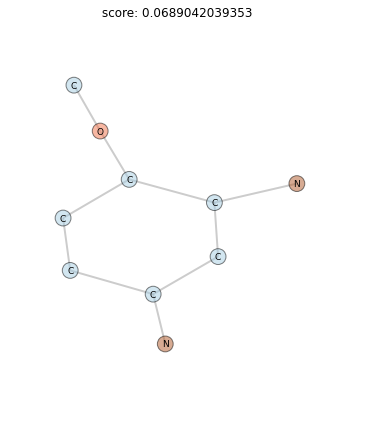

Graph id: 52
grammar
iteration:0
candidates
Working with 1 cores
Working with 0 cores
iteration:1
propose failed.. reason is that propose_single_cip failed.
Working with 9 cores
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Exception: propose failed.. reason is that propose_single_cip failed.

iteration:2
Working with 1 cores
iteration:3
Working with 1 cores
iteration:4
Working with 1 cores
iteration:5
Working with 0 cores
printing le errer


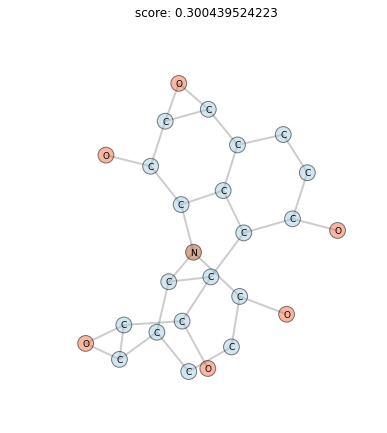

Graph id: 53
iteration:0
grammar
candidates
Working with 2 cores
Working with 0 cores
iteration:1
propose failed.. reason is that propose_single_cip failed.
Working with 1 cores
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Exception: propose failed.. reason is that propose_single_cip failed.

iteration:2
iteration:0
Working with 2 cores
Working with 6 cores
iteration:3
iteration:1
Working with 6 cores
Working with 6 cores
iteration:4
iteration:2
Working with 9 cores
Working with 4 cores
iteration:5
iteration:3
Working with 1 cores
Working with 2 cores
iteration:6
iteration:4
Working with 6 cores
Working with 1 cores
iteration:7
iteration:5
Working with 3 cores
Working with 1 cores
iteration:8
iteration:6
Working with 2 cores
Working with 1 cores
iteration:9
iteration:7
Working with 10 cores
Working with 3 cores
iteration:10
iteration:8
Work

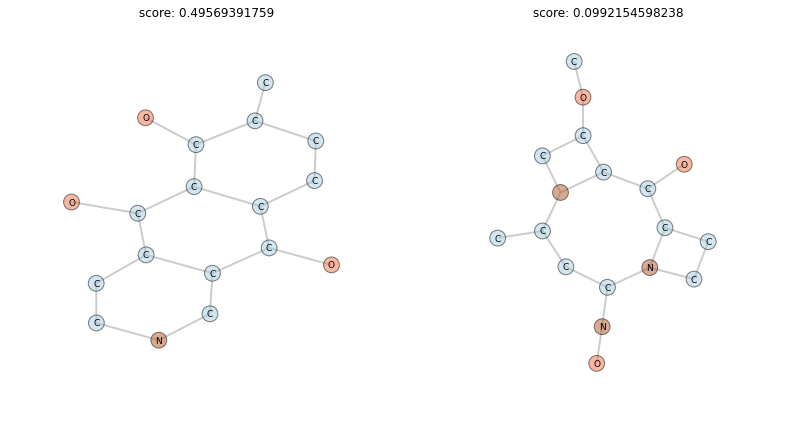

Graph id: 54
Working with 1 cores
candidates
candidates
iteration:11
Working with 0 cores
candidates
candidates
candidates
Working with 0 cores
Working with 0 cores
Working with 0 cores
Working with 0 cores
Working with 1 cores
propose failed.. reason is that propose_single_cip failed.
propose failed.. reason is that propose_single_cip failed.
propose failed.. reason is that propose_single_cip failed.
propose failed.. reason is that propose_single_cip failed.
propose failed.. reason is that propose_single_cip failed.
iteration:12
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Exception: propose failed.. reason is that propose_single_cip failed.

Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Excepti

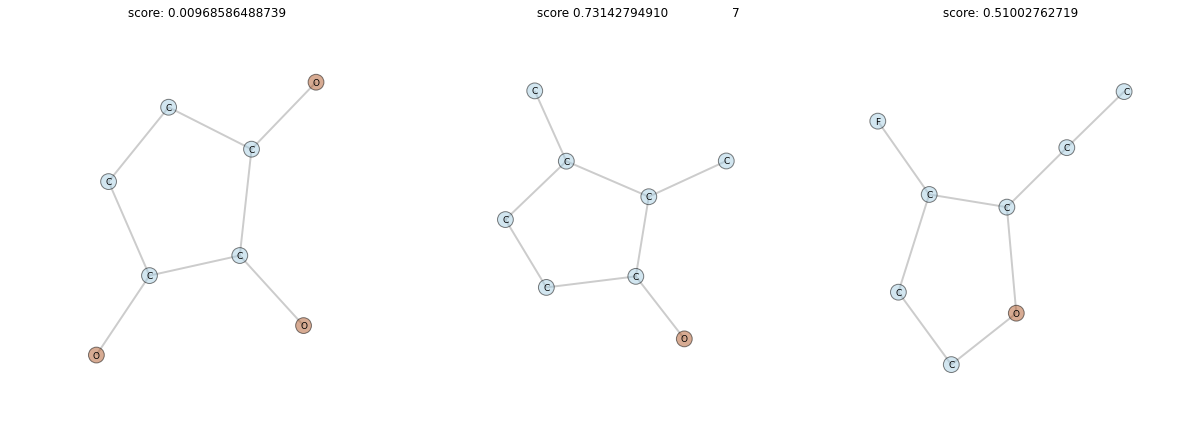

Graph id: 55
candidates
candidates
Working with 0 cores
Working with 0 cores
propose failed.. reason is that propose_single_cip failed.
propose failed.. reason is that propose_single_cip failed.
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Exception: propose failed.. reason is that propose_single_cip failed.

Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 231, in _sample
    if self._accept(graph, candidate_graph):
  File "graphlearn/graphlearn.py", line 377, in _propose
Exception: propose failed.. reason is that propose_single_cip failed.



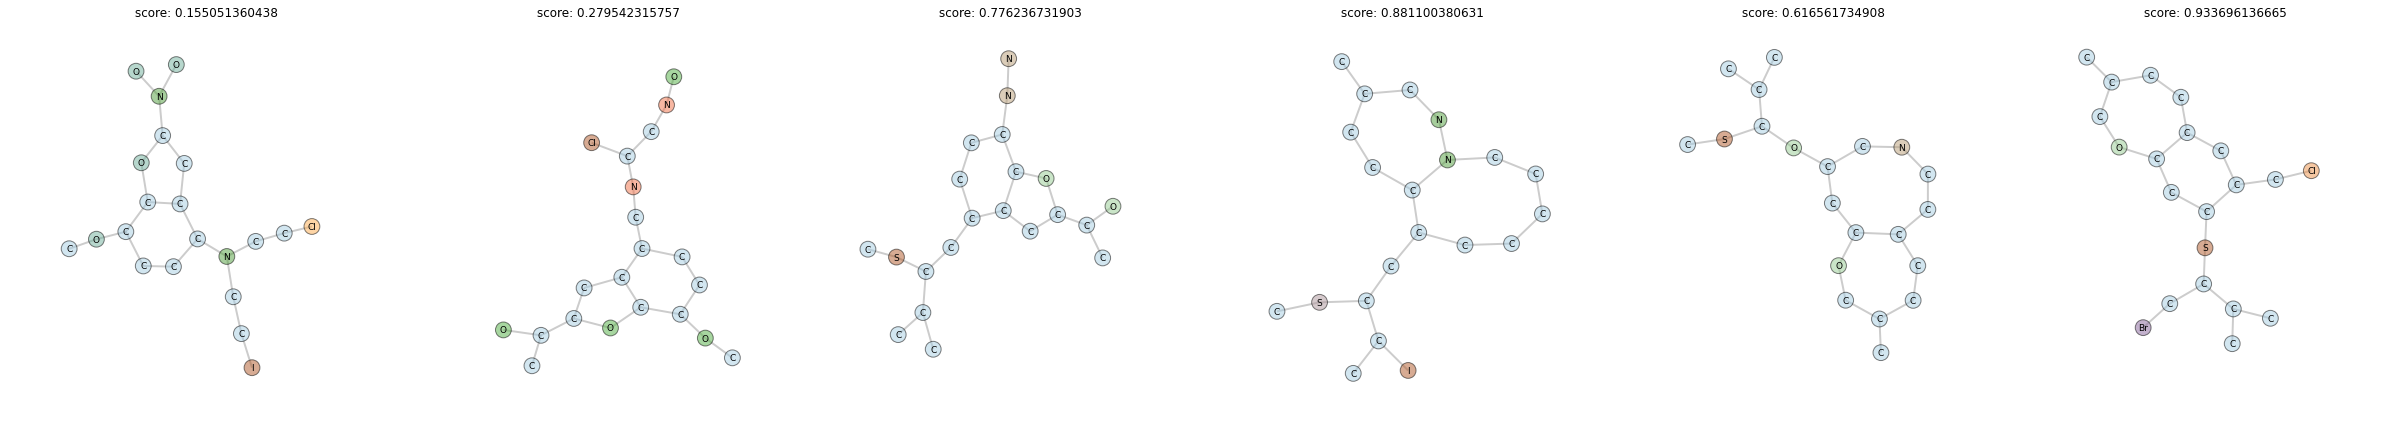

Graph id: 56


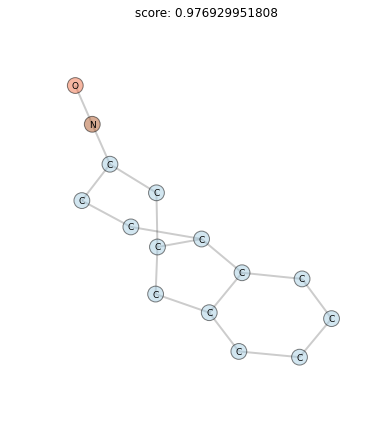

Graph id: 57


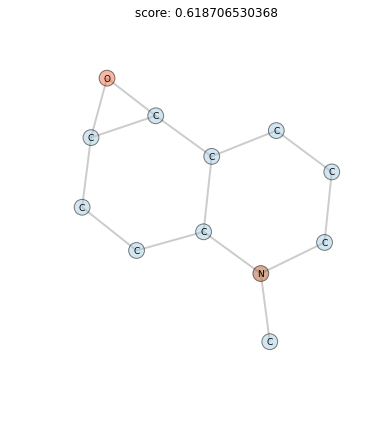

Graph id: 58


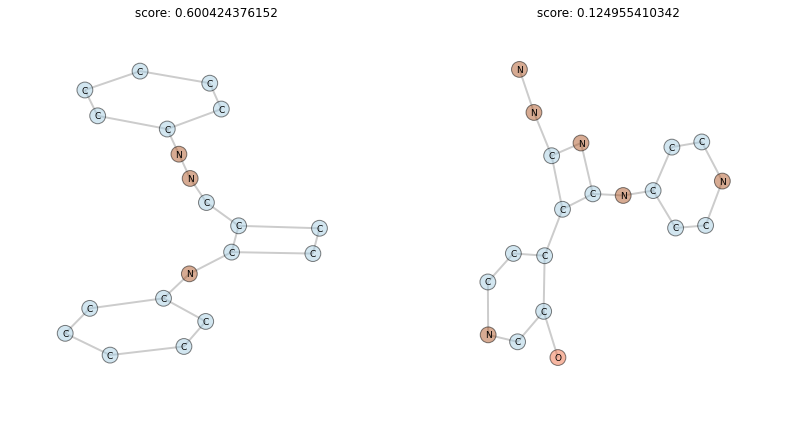

Graph id: 59


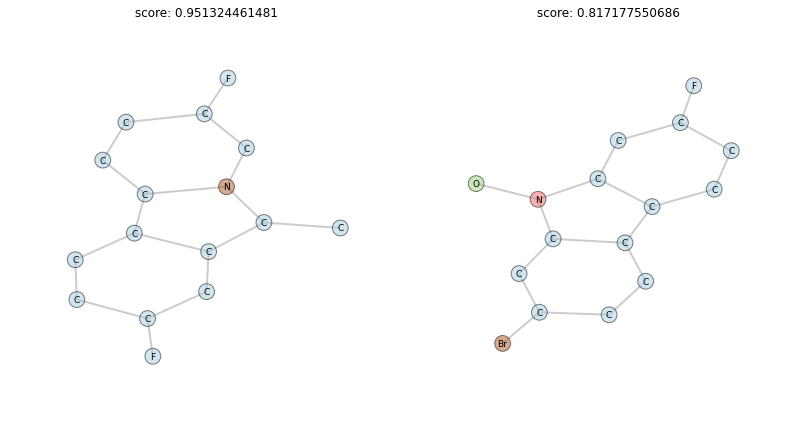

Graph id: 60


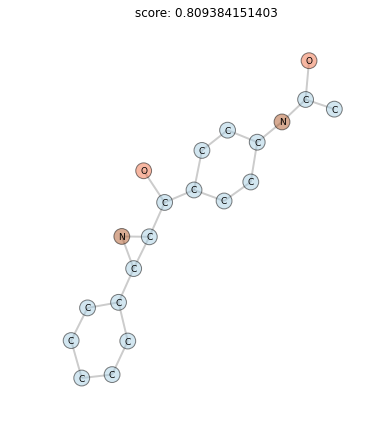

Graph id: 61


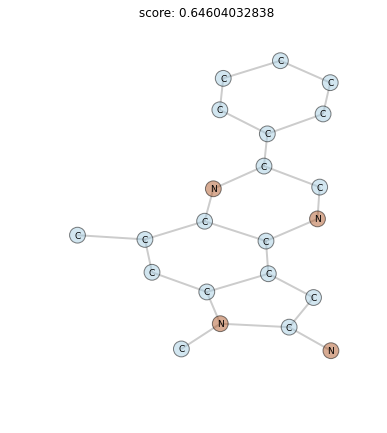

CPU times: user 11.1 s, sys: 1.27 s, total: 12.3 s
Wall time: 29.8 s


In [20]:
%%time
'''
Graph sampling
'''
graphs = get_graphs(size=100)
id_start=50
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)
n_steps=60
sampler.feasibility_checker.draw_problem=False
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        n_samples=6,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=-1,
                        accept_annealing_factor=0.9,
                        probabilistic_core_choice=False,
                        burnout=0,
                        select_cip_max_tries=200,
                        keep_duplicates=False)

from graphlearn.utils.draw import draw_graph_set_graphlearn, get_score_of_graph
from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    draw_graph_set_graphlearn(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook=get_score_of_graph)

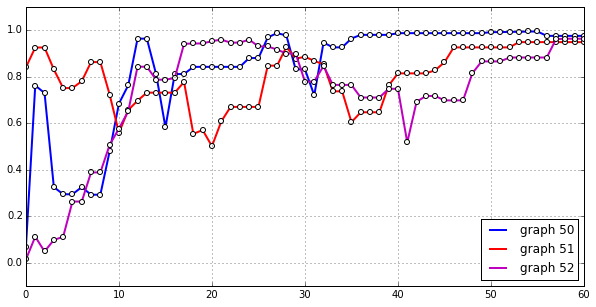

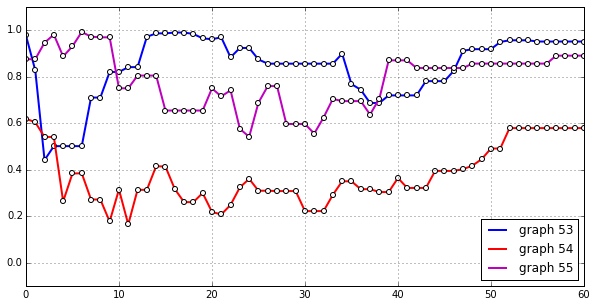

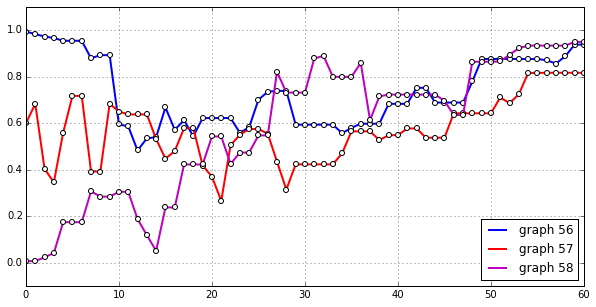

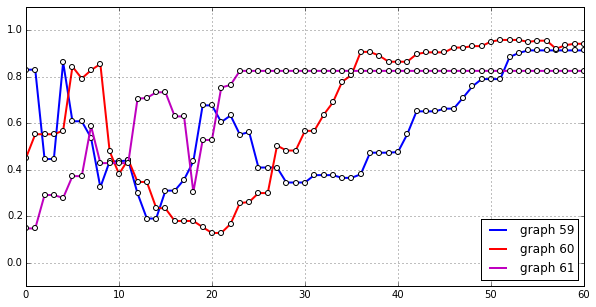

In [19]:
from itertools import islice
import numpy as np
import pylab as plt
step=n_steps
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None', markerfacecolor='white', marker='o', markeredgewidth=1,markersize=5)
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()